# Deep Learning Project

The current project relies on using CNNs in order to process sperm data. The goal is to develop a classifier able to identify sperm cells.

The model is not yet fuly defined. We will start with a standard CNN to Dense Layer.

The goal is for images to be loaded into the CNN. The CNN will will then perform feature extraction and those will be fed to the final model.

## Step 1 - Create the pipeline

The Deep learning model will be made out of 2 different parts: 

1. A CNN that takes the images as inputs and performs feature extraction.
2. A dense, fully connected layer that will perform classification itself with the features.

In [1]:
#import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import matplotlib.image as mpimg
%matplotlib inline

#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#Classification
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

sns.set()
#import keras
from tensorflow import keras

import glob
import cv2
import shutil
import random
import Augmentor

# Step 2: Label images

In this case, we have a folder with 1132 image - SCIAN-MorphoSpermGS folder - https://cimt.uchile.cl/gold10/. Each image is 35 x 35 pixels and has been classified by 3 experts. We will use majority vote result as target. Each image will need to be loaded and the dataset will need to be created.

#### This will yield a dataset with the picture name and the label.

In [2]:
#Select the path where you've put your dataset provided in Moodle

#step 1: change directory back
os.chdir('../Dataset')
path = os.getcwd()
files = os.listdir(path)

In [3]:
#1 - load txt file
dataframe = pd.read_csv(path + '\PA-expert-annotations.txt', sep = '\\t', header = None, engine = 'python')
dataframe

,0,1,2,3,4
0,p1-pl2-sample01/Sperm_01,5,5,5,5
1,p1-pl2-sample01/Sperm_02,1,5,5,5
2,p1-pl2-sample01/Sperm_03,0,0,0,0
3,p1-pl2-sample01/Sperm_04,1,5,5,5
4,p1-pl2-sample01/Sperm_05,0,0,0,0
...,...,...,...,...,...
1127,p5-pl1-sample20/Sperm_07,1,5,5,5
1128,p5-pl1-sample20/Sperm_09,1,1,5,1
1129,p5-pl1-sample20/Sperm_11,1,1,5,1
1130,p5-pl1-sample20/Sperm_12,5,5,5,5


a. Start by most standard preprocessing of Dataframe

In [4]:
#editions to target dataset
dataframe.rename(columns={0 :"Sperm_Pic", 1: 'Expert_1', 2: 'Expert_2', 3: 'Expert_3', 4: 'Majority_Vote'}, inplace = True)
dataframe['Sperm_Pic'] = dataframe['Sperm_Pic'].str.replace('/S', '-s')
dataframe['Majority_Vote'] = dataframe['Majority_Vote'].replace(5, 4)


#add ch_00 to all rows:
dataframe['Sperm_Pic'] = 'ch00_' + dataframe['Sperm_Pic'] + '.tif'

#Drop all irrelevant features
dataframe = dataframe.drop(['Expert_1', 'Expert_2', 'Expert_3'], axis = 1)

#Show
dataframe

,Sperm_Pic,Majority_Vote
0,ch00_p1-pl2-sample01-sperm_01.tif,4
1,ch00_p1-pl2-sample01-sperm_02.tif,4
2,ch00_p1-pl2-sample01-sperm_03.tif,0
3,ch00_p1-pl2-sample01-sperm_04.tif,4
4,ch00_p1-pl2-sample01-sperm_05.tif,0
...,...,...
1127,ch00_p5-pl1-sample20-sperm_07.tif,4
1128,ch00_p5-pl1-sample20-sperm_09.tif,1
1129,ch00_p5-pl1-sample20-sperm_11.tif,1
1130,ch00_p5-pl1-sample20-sperm_12.tif,4


b. Place images on Folder based on image Label

In [5]:
os.chdir('Partial-Agreement-Images')
path = os.getcwd()

In [6]:
path

'C:\\Users\\Ricardo Santos\\Desktop\\Mestrado Ricardo\\Ano 1\\Spring Semester\\Deep\\Deep_Learning_Project\\Dataset\\Partial-Agreement-Images'

In [7]:
imgs = []

for image in glob.glob(path+'/*.tif'):
        
    imgs.append(cv2.imread(image))
    
    #names of each sample in the image and dataframe are different, gotta deal with this here to match them

    img_name = image.split('\\')[-1]
    check_length = img_name.split('-')[-2]
    if len(check_length) == 7:
        img_name = img_name[:18] + '0' + img_name[18:]
    check_length = img_name.split('-')[-1]
    if len(check_length) == 10:
        img_name = img_name[:-5] + '0' + img_name[-5:]
    img_name = img_name[:-6] + '_' + img_name[-6:]
   
    #path of each class
    path0 = path+'\\class0'
    path1 = path+'\\class1'
    path2 = path+'\\class2'
    path3 = path+'\\class3'
    path4 = path+'\\class4'
   
    #creates folders to store images from eacg category, if not exists already
    #requires dirs to exist - otherwise enters infinite loop and we have to restrat script
    if not os.path.isdir(path0):
        path = path4
        os.mkdir(path)
        path = path3
        os.mkdir(path)
        path = path2
        os.mkdir(path)
        path = path1
        os.mkdir(path)
        path = path0
        os.mkdir(path)

    #creates copy of image based on label
    maj_vote = dataframe[dataframe['Sperm_Pic'].str.contains(img_name)]['Majority_Vote']

    if maj_vote.values == 4:
        shutil.copy(image, path4)
    if maj_vote.values == 3:
        shutil.copy(image, path3)
    if maj_vote.values == 2:
        shutil.copy(image, path2)
    if maj_vote.values == 1:
        shutil.copy(image, path1)
    if maj_vote.values == 0:
        shutil.copy(image, path0)        

In [8]:
#comparing to images on each folder
dataframe['Majority_Vote'].value_counts()

4    656
1    228
0    100
2     76
3     72
Name: Majority_Vote, dtype: int64

c. Create Folders for Training, Validation and Test Data
The Current solution is somewhat innefficient because it requires the creation of 2 copies of image.

In [10]:
classes_dir = ['/class0', '/class1', '/class2', '/class3', '/class4']

val_ratio = 0.2
test_ratio = 0.2

if not os.path.isdir(path + '/train'):

    for cls in classes_dir:
    
        #creates train and test folders, with each class separated inside
        os.makedirs(path +'/train' + cls)
        os.makedirs(path +'/val' + cls)
        os.makedirs(path +'/test' + cls)


        # Creating partitions of the data after shuffeling
        src = path + cls # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio - test_ratio)), 
                                                               int(len(allFileNames)* (1 - val_ratio))])
        
        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    
        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, path +'/train' + cls)

        for name in val_FileNames:
            shutil.copy(name, path +'/val' + cls)

        for name in test_FileNames:
            shutil.copy(name, path +'/test' + cls)
        

d. Augment images

In [11]:
# Define augmentation pipelines
class_0 = Augmentor.Pipeline(path+'/train/class0')
class_1 = Augmentor.Pipeline(path+'/train/class1')
class_2 = Augmentor.Pipeline(path+'/train/class2')
class_3 = Augmentor.Pipeline(path+'/train/class3')

# Define different augmentations depending on the pipeline; options are limited since we're working with microscopy data

#visit: https://augmentor.readthedocs.io/en/master/userguide/mainfeatures.html#rotating
#options are:
#Perspective skewing: does not make sense; microscopy data
###Elastic distortion: could work, but I'm afraid it'll actually deform the shape of the sper cell, which is what is picked up to classify it; could be detremental...
###Rotation: makes sense! But no more than 5 degrees left or right...
#Shear: does not make sense?
#Cropping: does not make sense.
###Mirroring: yes! both vertically and horizontally, randomly.


#rotate by a maximum of 5 degrees
class_0.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_1.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_2.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_3.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)

#mirroring, vertical or horizontal, randomly
class_0.flip_random(probability=0.7)
class_1.flip_random(probability=0.7)
class_2.flip_random(probability=0.7)
class_3.flip_random(probability=0.7)

# Augment images to the same proportion as existing ones in class 4 (majority class)
class_0.sample(393-60)
class_1.sample(394-136)
class_2.sample(394-45)
class_3.sample(394-43)

Initialised with 60 image(s) found.
Output directory set to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\Dataset\Partial-Agreement-Images/train/class0\output.Initialised with 136 image(s) found.
Output directory set to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\Dataset\Partial-Agreement-Images/train/class1\output.Initialised with 45 image(s) found.
Output directory set to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\Dataset\Partial-Agreement-Images/train/class2\output.

Processing <PIL.Image.Image image mode=L size=35x35 at 0x180130C5520>:   7%|▏  | 23/333 [00:00<00:02, 123.83 Samples/s]

Initialised with 43 image(s) found.
Output directory set to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\Dataset\Partial-Agreement-Images/train/class3\output.

Processing <PIL.Image.Image image mode=L size=35x35 at 0x18013106550>: 100%|██| 333/333 [00:00<00:00, 575.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=35x35 at 0x1801313B0A0>: 100%|██| 258/258 [00:00<00:00, 503.90 Samples/s]
Processing <PIL.Image.Image image mode=L size=35x35 at 0x180132804F0>: 100%|██| 349/349 [00:00<00:00, 550.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=35x35 at 0x18011E20820>: 100%|██| 351/351 [00:00<00:00, 510.91 Samples/s]


## Step 3 - Load Data

In [12]:
#load image
from keras.preprocessing.image import ImageDataGenerator

#to play around with these
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5, #rotates images from -5 to 5 degrees
                                   width_shift_range = 0.06, #translates images by 6% to left or right
                                   height_shift_range = 0.06, #translates images by 6% up and down
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   brightness_range=[0.2,1.2], 
                                   fill_mode='nearest',
                                   ) #darkens or brightens the images anywhere between 0 and 20%
                                   #shear_range = 0.2, #doesn't make sense here
                                   #zoom_range = 0.2 #does not make sense coz this is microscopy data, all taken with same magnification


val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

#test different color maps -  class modes and cross validation types
training_set = train_datagen.flow_from_directory(path+'/train',
                                                 target_size = (32, 32),
                                                 batch_size = 32,
                                                 class_mode="categorical",
                                                 color_mode = 'rgb')

val_set = test_datagen.flow_from_directory(path+'/val',
                                            target_size = (32, 32),
                                            batch_size = 32,
                                            class_mode="categorical",
                                            color_mode = 'rgb')

test_set = test_datagen.flow_from_directory(path+'/test',
                                            target_size = (32, 32),
                                            batch_size = 32,
                                            class_mode="categorical",
                                            color_mode = 'rgb')

Found 1968 images belonging to 5 classes.
Found 226 images belonging to 5 classes.
Found 229 images belonging to 5 classes.


In [13]:
#Create SETS

x_train,y_train = next(training_set)

x_val,y_val = next(val_set)

x_test, y_test = next(test_set)

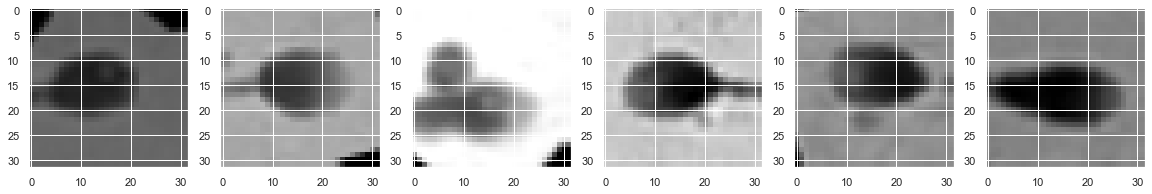

In [14]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(x_train[i])

In [15]:
x_train.shape

(32, 32, 32, 3)

In [16]:
y_train.shape

(32, 5)

In [17]:
x_val.shape

(32, 32, 32, 3)

## Step 4 - Design and initialize model

In [18]:
def image_cnn_standard_model():
    '''creates an image classification model that uses 2 Convolutional CNNs layers (with maxpooling) and feeds the data through
    a dense connected layer. This is trial and error there is no specific reason for 2 layers'''
    cnn_model = keras.Sequential([

        #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=64, kernel_size=(3,3),  padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
        #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(4,4), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        #keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
                #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=128, kernel_size=(4,4), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        #keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        #the result of kthe CNN is then flattened and placed into the 
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        
        keras.layers.Dense(256, activation='relu'),
        
        #final layer, is output, 1 out of 5 possible results
        #0 Normal, 1 Tapered, 2 Pyriform, 3 Small, 5 Amorphous
        keras.layers.Dense(5, activation='softmax')
    ])
    
    return cnn_model

# Step 5: Compile, Train and Predict

In [ ]:
#compile model: First try
cnn_model = image_cnn_standard_model()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping criteria
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=1000, restore_best_weights = True)

In [ ]:
#fit model
history = cnn_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=4000, verbose = 1, callbacks = [es])
#history = cnn_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=500, verbose = 1)
# evaluate the model
_, train_acc = cnn_model.evaluate(x_train, y_train, verbose=0)
_, val_acc = cnn_model.evaluate(x_val, y_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


cnn_model.save("model_1.h5")

In [ ]:
#Performance do primeiro teste

test_loss, test_acc = cnn_model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

In [ ]:
#Model Summary
cnn_model.summary()

### Make Predictions

Code still needs improvement

These predictions are gated by batch size

Let's try and improve it with bruteforce Hyperparam optimization whiole being on the lookout for other ways to improve performance. Model is predicting all as Amorphous.

In [ ]:
np.argmax(cnn_model.predict(x_test), axis = 1)

In [ ]:
np.argmax(y_test, axis = 1)

# Step 6 - Benchmarks and other tests

Try and compare the models performance with other standardly used models:

AlexNet

In [ ]:
#ALEX NET

#Importing library
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization


#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(5))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

In [ ]:
# Compiling the model
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [ ]:
#fit model

history = AlexNet.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=4000, verbose = 1, callbacks = [es])
# evaluate the model
_, train_acc = AlexNet.evaluate(x_train, y_train, verbose=0)
_, val_acc = AlexNet.evaluate(x_val, y_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
AlexNet.save("Alex_net.h5")

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
np.argmax(AlexNet.predict(x_test), axis = 1)

In [ ]:
np.argmax(y_test, axis = 1)

## Transfer Learning with RESNET50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


res50model = Sequential()

#Layer 1: RES50 without top layer
res50model.add(ResNet50(weights='imagenet', input_shape= (32,32,3),
                 include_top = False, classes=5,))

#Layer 2: RES50 without top layer
res50model.add(Flatten())
res50model.add(Dense(5, activation = 'softmax'))

#freeze layers in resnet - weights obtained with IMAGENET challenge, we only train final layer
res50model.layers[0].trainable = False

In [ ]:
res50model.summary()

In [ ]:
res50model.output_shape

In [ ]:
#preprocess data for resnet

res_train, res_targ_train = preprocess_input(x_train), preprocess_input(y_train)
res_val, res_targ_val = preprocess_input(x_val), preprocess_input(y_val)
res_test, res_targ_val = preprocess_input(x_test), preprocess_input(y_test)

In [ ]:
res_train.shape

In [ ]:
res_targ_train.shape

In [ ]:
res_val.shape

In [ ]:
res_targ_val.shape

In [ ]:
#compile

res50model.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [ ]:
#fit model

res_history = res50model.fit(res_train, res_targ_train, validation_data = (res_val, res_targ_val), epochs=4000, verbose = 1, callbacks = [es])
# evaluate the model
_, train_acc = AlexNet.evaluate(res_train, res_targ_train, verbose=0)
_, val_acc = AlexNet.evaluate(res_val, res_targ_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
res50model.save("Res50_net.h5")

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()